# RESEARCH QUESTION: Consumption forecasting.
We can use the weather forecast for the same day, but consumnption forecasting stops 5 days in advance.
It is said that the forecase is made at around 10 am., but considering the rest of the information we assume the following:
If the forecast is made for the 19th we can use the hourly consumption until 23:59 the 13th. If it really is only untill 10:00 for the 13th, that can be adjusted easily.

Explain methods used in pipeline
1. Domain understanding
2. Data acquisition
3. Data exploration and visualization
4. Data preprocessing: cleaning, transformation, normalization
5. Feature engineering: construction, selection
6. Model engineering: construction, selection, hyperparameter tuning
7. Evaluation: cross-validation, comparing with baselines

Time series components:
- Seasonal
- Trend
- Irregular

This will only be included if we use statistical models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype_mapping = {
    'location': 'category',
    'consumption': 'float',
    'temperature': 'float',
}
df = pd.read_csv('data/consumption_temp.csv', dtype=dtype_mapping, parse_dates=['time'])
# set column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49494 entries, 0 to 49493
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         49494 non-null  datetime64[ns]
 1   location     49494 non-null  category      
 2   consumption  49494 non-null  float64       
 3   temperature  49494 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [4]:
df.head()

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8


In [5]:
# get counts of each location
df['location'].value_counts()

location
bergen         8641
oslo           8641
stavanger      8641
tromsø         8641
trondheim      8641
helsingfors    6289
Name: count, dtype: int64

In [6]:
# drop location helsingfors
df = df[df['location'] != 'helsingfors']
df['location'] = df['location'].cat.remove_unused_categories()
df['location'].value_counts()

location
bergen       8641
oslo         8641
stavanger    8641
tromsø       8641
trondheim    8641
Name: count, dtype: int64

In [7]:
# explode data based on location
# Pivot for consumption
df_consumption = df.pivot(index='time', columns='location', values='consumption')
df_consumption.columns = [f'{col}_consumption' for col in df_consumption.columns]

# Pivot for temperature
df_temperature = df.pivot(index='time', columns='location', values='temperature')
df_temperature.columns = [f'{col}_temp' for col in df_temperature.columns]

# Merge the two dataframes on time
df_merged = df_consumption.merge(df_temperature, left_index=True, right_index=True)
df_merged.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp
time,,,,,,,,,,
2022-04-07 21:00:00,1.113325,4.092830,2.057858,1.246582,1.970098,-0.3,1.0,1.3,-3.9,-2.8
2022-04-07 22:00:00,1.050327,3.818095,1.918996,1.180321,1.839443,0.0,0.4,0.8,-4.3,-3.3
2022-04-07 23:00:00,1.008794,3.660981,1.821749,1.138952,1.747675,-0.5,0.3,1.1,-5.1,-3.8
2022-04-08 00:00:00,0.984202,3.584066,1.782011,1.140786,1.703176,-1.1,0.2,1.1,-5.7,-4.2
2022-04-08 01:00:00,0.950335,3.549536,1.744253,1.140567,1.694300,-0.7,0.4,1.0,-3.9,-4.1


In [8]:
# add hour column
df_merged['hour'] = df_merged.index.hour
# add weekday column
df_merged['weekday'] = df_merged.index.weekday
df_merged.head()

,bergen_consumption,oslo_consumption,stavanger_consumption,tromsø_consumption,trondheim_consumption,bergen_temp,oslo_temp,stavanger_temp,tromsø_temp,trondheim_temp,hour,weekday
time,,,,,,,,,,,,
2022-04-07 21:00:00,1.113325,4.092830,2.057858,1.246582,1.970098,-0.3,1.0,1.3,-3.9,-2.8,21,3
2022-04-07 22:00:00,1.050327,3.818095,1.918996,1.180321,1.839443,0.0,0.4,0.8,-4.3,-3.3,22,3
2022-04-07 23:00:00,1.008794,3.660981,1.821749,1.138952,1.747675,-0.5,0.3,1.1,-5.1,-3.8,23,3
2022-04-08 00:00:00,0.984202,3.584066,1.782011,1.140786,1.703176,-1.1,0.2,1.1,-5.7,-4.2,0,4
2022-04-08 01:00:00,0.950335,3.549536,1.744253,1.140567,1.694300,-0.7,0.4,1.0,-3.9,-4.1,1,4


# Pre process: standarization

In [9]:
def standardize_data(df):
    # Per location
    # standardize data
    np_df = df_merged.to_numpy()
    for i in range(5):
        # get mean and std for consumption
        consumption_mean = np_df[:, i].mean()
        consumption_std = np_df[:, i].std()

        # get mean and std for temperature
        temp_mean = np_df[:, i+5].mean()
        temp_std = np_df[:, i+5].std()

        # standardize data
        np_df[:, i] = (np_df[:, i] - consumption_mean) / consumption_std
        np_df[:, i+5] = (np_df[:, i+5] - temp_mean) / temp_std
    return np_df
np_df = standardize_data(df_merged)

# Split data

We split the data into training, validation and test-set. 
To ensure no leaks we make sure each period does not have overlap.
This however leads to significantly less data than if we would allow for overlap.

To also ensure that the data is varied we split on a cyclic basis to cover seasonality variety in all splits. 
This also leads to even more loss of data... but we think it makes sense.

It is a pity there is not more data. 1 year is awfully little data and 5 days delay is an awful lot. 
Setting up a system to get reliable consumptions hours or just 1 day before forecasts could be looked into. (We can also test here how much better the model performs with data closer to forecast)

In [56]:
# create a function to makes splits of the data
def split_data(matrix, train_size, val_size, splits):
    # matrix: numpy to split
    # train_size: size of the training data in float percentage
    # val_size: size of the validation data in float percentage
    # splits: number of splits to make
    train = []
    val = []
    test = []
    split_size = matrix.shape[0] // splits
    # loop through the data
    for i in range(splits):
        # get the start and end index of the split
        start = i * split_size
        end = (i + 1) * split_size
        # get the data
        data = matrix[start:end]
        # get the train and validation data
        train.append(data[:int(train_size * data.shape[0])])
        val.append(data[int(train_size * data.shape[0]):int((train_size + val_size) * data.shape[0])])
        test.append(data[int((train_size + val_size) * data.shape[0]):])
    # return the split data
    return np.array(train), np.array(val), np.array(test)

In [57]:
# split the data
train, val, test = split_data(np_df, 0.6, 0.2, 3)

In [58]:
# check the shape of the data
train.shape, val.shape, test.shape

((3, 1728, 12), (3, 576, 12), (3, 576, 12))

# Baseline prediction

In [ ]:
# NB: We must assume when the first day we can predict is based on what our other models need.
# If our tabular model uses 1 week lags we can first predict with our baseline on day 15.
# The more lags we use, the less test-data we have.

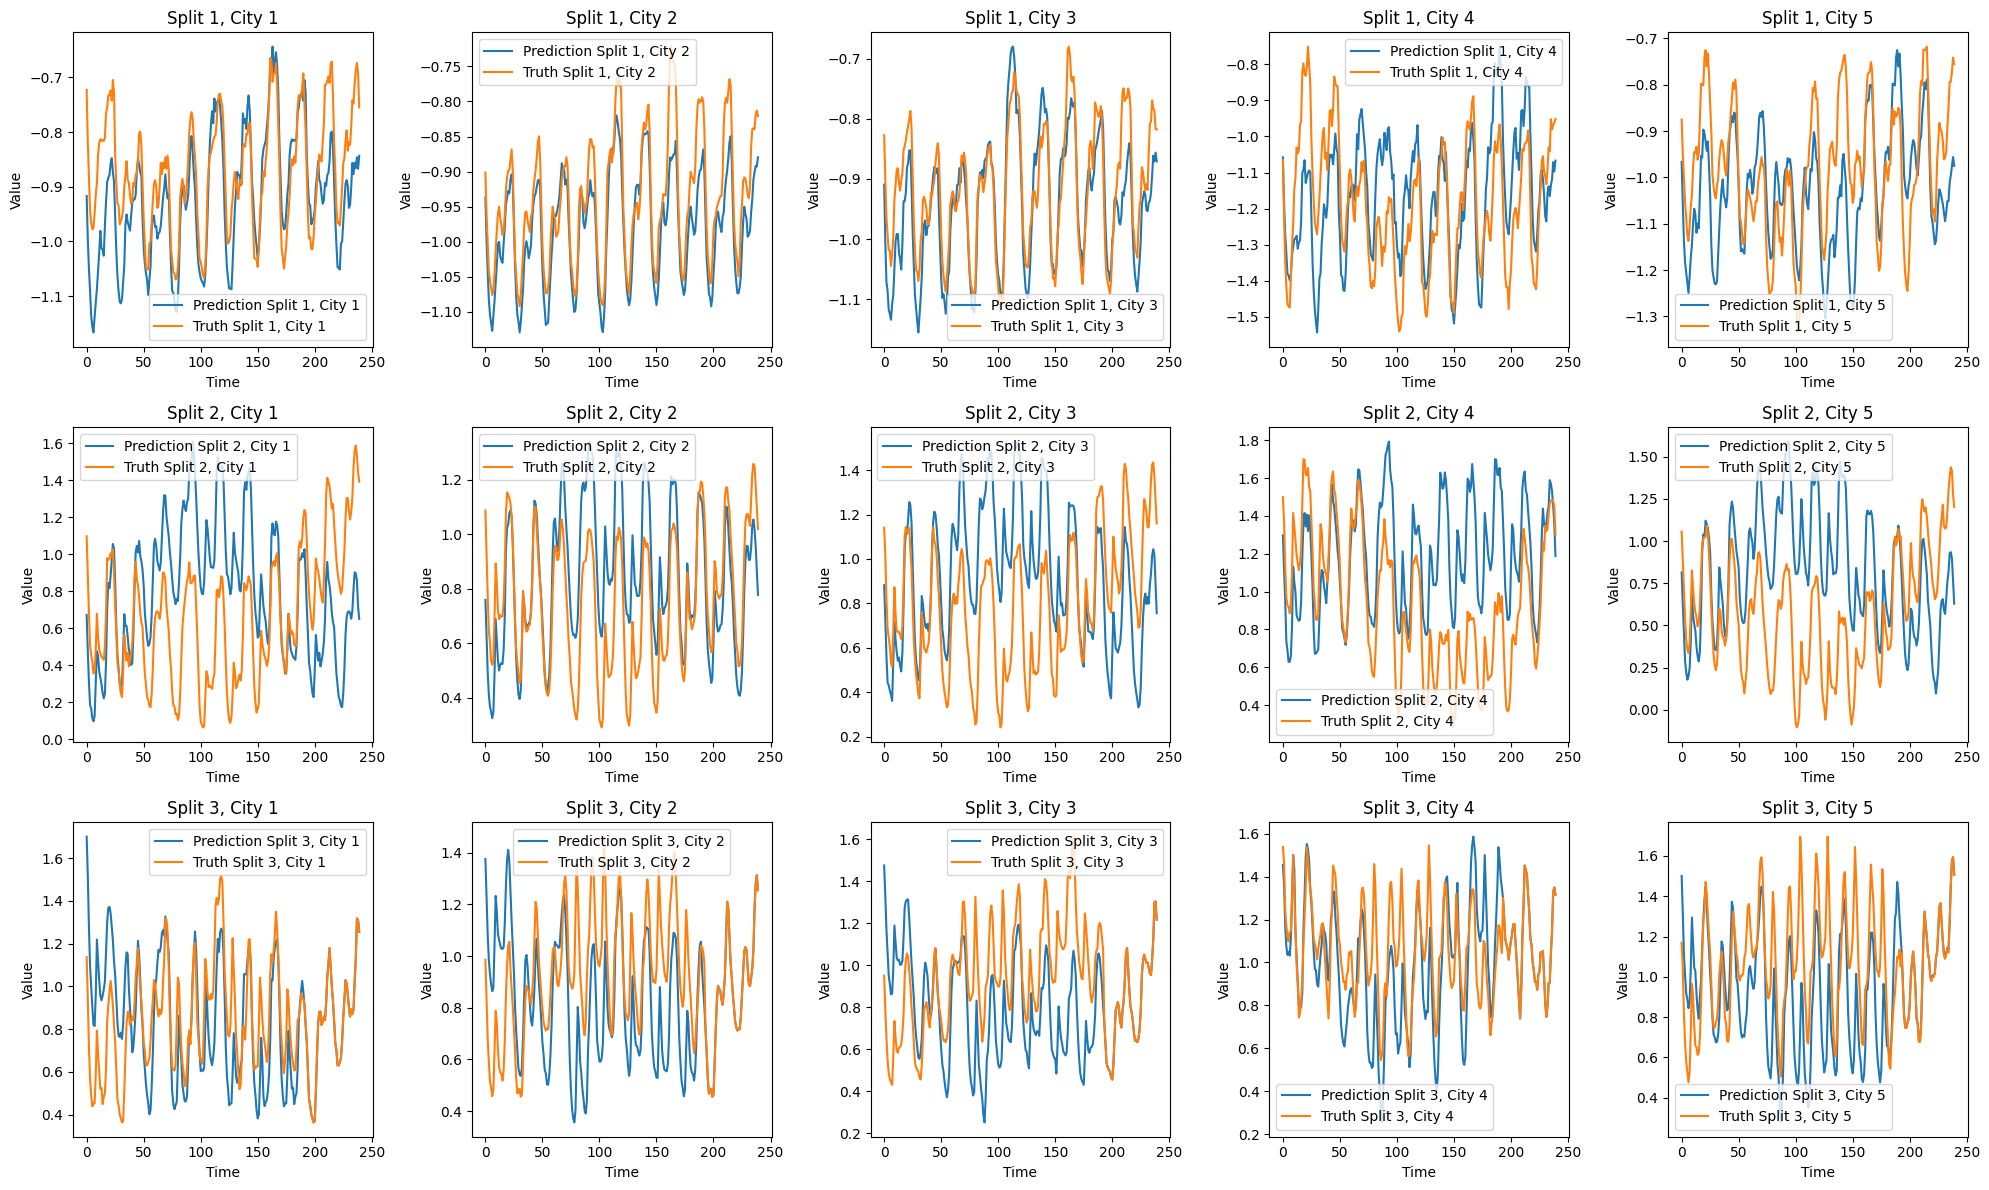

Metrics per City and Split:


,Split,City,MAE,MSE,RMSE,MAPE
0,1,1,0.070875,0.007851,0.088605,8.409434
1,1,2,0.042903,0.002705,0.052007,4.799358
2,1,3,0.047885,0.003638,0.060313,5.447125
3,1,4,0.135665,0.024363,0.156086,11.977054
4,1,5,0.107862,0.015979,0.126408,11.477193
5,2,1,0.395068,0.209458,0.457666,104.744059
6,2,2,0.173805,0.042776,0.206824,28.162089
7,2,3,0.296174,0.114747,0.338743,46.404362
8,2,4,0.336345,0.162281,0.402841,48.151311
9,2,5,0.421214,0.235118,0.484889,264.470467



Average Metrics per City Across Splits:


,City,Split,MAE,MSE,RMSE,MAPE
0,1,2.0,0.211101,0.090426,0.259529,45.364222
1,2,2.0,0.138081,0.038139,0.173797,18.522926
2,3,2.0,0.191482,0.069349,0.232832,25.766831
3,4,2.0,0.205435,0.076153,0.254471,24.790313
4,5,2.0,0.247918,0.112761,0.302190,98.901425



Overall Mean Metrics:
Mean MAE: 0.19880357890433517
Mean MSE: 0.07736574582327707
Mean RMSE: 0.24456352212977034
Mean MAPE: 42.669143503502454


In [121]:
# Using last week consumption as prediction
# Setup table to get metrics
metrics_dict = {'Split': [], 'City': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE': []}

# Set up the 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

for i in range(3):
    for j in range(5):  # For each city
        # NB: here we need to change if we use more/less lags in tabular model to have equal comparison
        prediction = test[i, 168:-168, j]
        truth = test[i, 168*2:, j]
        axis = np.arange(prediction.shape[0])
        # Calculate mean absolute error
        mae = np.mean(np.abs(prediction - truth))
        # Calculate mean squared error
        mse = np.mean(np.square(prediction - truth))
        # Calculate root mean squared error
        rmse = np.sqrt(mse)
        # Calculate mean absolute percentage error
        mape = np.mean(np.abs((prediction - truth) / truth)) * 100

        # Store metrics in the dictionary
        metrics_dict['Split'].append(i+1)
        metrics_dict['City'].append(j+1)
        metrics_dict['MAE'].append(mae)
        metrics_dict['MSE'].append(mse)
        metrics_dict['RMSE'].append(rmse)
        metrics_dict['MAPE'].append(mape)
        
        # Plot the prediction and truth
        ax = axs[i, j]
        ax.plot(axis, prediction, label=f'Prediction Split {i+1}, City {j+1}')
        ax.plot(axis, truth, label=f'Truth Split {i+1}, City {j+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_title(f'Split {i+1}, City {j+1}')
        ax.legend()

# Adjust layout so that plots do not overlap
plt.tight_layout()

# Display all the plots
plt.show()

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Calculate the average of the metrics for each city across splits
avg_metrics_df = metrics_df.groupby('City').mean().reset_index()

# Display the metrics table
print("Metrics per City and Split:")
display(metrics_df)

# Display the average metrics per city
print("\nAverage Metrics per City Across Splits:")
display(avg_metrics_df)

# Print the overall means
print(f'\nOverall Mean Metrics:')
print(f'Mean MAE: {metrics_df["MAE"].mean()}')
print(f'Mean MSE: {metrics_df["MSE"].mean()}')
print(f'Mean RMSE: {metrics_df["RMSE"].mean()}')
print(f'Mean MAPE: {metrics_df["MAPE"].mean()}')

Potential for more here

Interesting note: When using 3 way split the test data for series 1 and 3 are SUPER similar, but split 2 is really different. Maybe something to note for the text. 
(it might show differently based on how many lags we account for)

# Model 1: Statistical

In [ ]:
# 

# Model 2: XGBoost / Tabular

Here we set up the data in a tabular format with lags.

There are so many choices to make here... I ahve no idea what is good and what is not. The best would be to try all, but there are WAY too many.
Can list some here:
- Should we have all cities data in the same dataset and predict or should we split per city.
- If we split per city should we train one model or all cities or different per city.
- What features should we include, just the relevant hour of prediction with lags or all hours previously (for a period).

If we just include everything we can test for which columns are good, but I give up on trying that...

I tried to include every feature, but got some matrix shape trouble. Won't bother fixing unless important.

In [64]:
train.shape

(3, 1728, 12)

In [ ]:
# This tries to use all features of the previous 9 days... There are some issues with shape, won't bother to fix it now.
# Just look past this
def tabulize_data_all(matrix):
    # matrix: numpy to tabulize (train, val or test)
    # return: numpy matrices: X, y
    splits = matrix.shape[0]
    X = []
    # get the consumption columns from the 15th day to the end
    y = matrix[:, 14*24:, :5]
    # loop through the splits
    for i in range(splits):
        for j in range(y.shape[1]):
            # get the consumption data from day 1 to 9
            consumption_features = matrix[i, j:j+8*24, :5]
            print(consumption_features.shape)
            temperature_features = matrix[i, j:j+15*24, 5:10]
            print(temperature_features.shape)
            time_features = np.tile(matrix[i, j+15*24, 10:], (5, 1)).T
            print(time_features.shape)
            # append the features
            X.append(np.concatenate([consumption_features, temperature_features, time_features]))

    # return the dataframes
    return np.array(X), np.array(y)

# X, y = tabulize_data_all(train)

In [111]:
# Create a dataset with:
# - the same hour consumption the two previous weeks
# - the temperature of the two previous weeks
# - the temperature forecast of the hour
# - the hour of the day
# - the day of the week
# X will be size (splits, features, cities)
# y will be size (splits, cities)
# NB: tabulize is probably the wrong word for this exact operation.
def tabulize_data_simple(matrix):
    # matrix: numpy to tabulize (train, val or test)
    # return: numpy matrices: X, y
    splits = matrix.shape[0]
    X = []
    # get the consumption columns from the 15th day to the end
    y = matrix[:, 14*24:, :5]
    # loop through the splits
    for i in range(splits):
        for j in range(y.shape[1]):
            # get the consumption data of the two previous weeks
            consumption_2_weeks_before = matrix[i, j, :5]
            consumption_1_week_before = matrix[i, j+7*24, :5]
            # get the temperature data of the two previous weeks
            temperature_2_weeks_before = matrix[i, j, 5:10]
            temperature_1_week_before = matrix[i, j+7*24, 5:10]
            # get the temperature forecast of the hour
            temperature_forecast = matrix[i, j+14*24, 5:10]
            # get the hour of the day
            hour = np.tile(matrix[i, j+14*24, 10], (5))
            # get the day of the week
            weekday = np.tile(matrix[i, j+14*24, 11], (5))
            # concatenate the features
            features = np.concatenate([consumption_2_weeks_before, consumption_1_week_before, temperature_2_weeks_before, temperature_1_week_before, temperature_forecast, hour, weekday])
            # append the features
            X.append(features)

    # return the dataframes
    return np.array(X).reshape((splits, -1, 5, 7)), np.array(y)

X, y = tabulize_data_simple(train)
X.shape, y.shape
    

((3, 1392, 5, 7), (3, 1392, 5))

In [113]:
# Create a train and validation set
X_train, y_train = tabulize_data_simple(train)
X_val, y_val = tabulize_data_simple(val)

In [114]:
import xgboost as xgb

In [115]:
# Initialize a list to hold the models for each city
models = []

# Loop through each city index
for city_index in range(5):  # Assuming there are 5 cities
    # Extract the features and targets for the current city
    city_features = X_train[:, :, city_index, :]  # Shape becomes (3, 1392, 7)
    city_targets = y_train[:, :, city_index]  # Shape becomes (3, 1392)

    # Reshape the data to 2D
    city_features_2d = city_features.reshape(-1, 7)  # Shape becomes (4176, 7)
    city_targets_2d = city_targets.flatten()  # Shape becomes (4176,)

    # Create DMatrix for the current city
    dtrain_city = xgb.DMatrix(city_features_2d, label=city_targets_2d)

    # Define XGBoost parameters for the current city's model
    params = {
        'max_depth': 3,
        'eta': 0.1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'  # or 'mae' or another suitable metric for your task
    }

    # Train the model for the current city
    num_boost_round = 100
    bst_city = xgb.train(params, dtrain_city, num_boost_round)

    # Store the model in the list
    models.append(bst_city)

ValueError: x and y must have same first dimension, but have shapes (240,) and (720,)

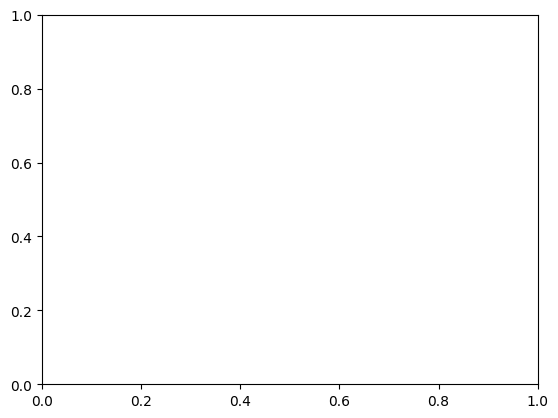

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'test_features' is your test features set with shape (3, 1392, 5, 7)
# And 'test_targets' is your test targets set with shape (3, 1392, 5)

# Initialize a list to hold the metrics for each city
mae_values = []
mse_values = []
rmse_values = []
mape_values = []

# Loop through each city index and model
for city_index, model in enumerate(models):
    # Extract the test features and targets for the current city
    city_test_features = X_val[:, :, city_index, :]  # Shape becomes (3, 1392, 7)
    city_test_targets = y_val[:, :, city_index]  # Shape becomes (3, 1392)

    # Reshape the test data to 2D
    city_test_features_2d = city_test_features.reshape(-1, 7)  # Shape becomes (4176, 7)
    city_test_targets_2d = city_test_targets.flatten()  # Shape becomes (4176,)

    # Create DMatrix for test set of the current city
    dtest_city = xgb.DMatrix(city_test_features_2d)
    
    # Predict using the trained model for the current city
    city_predictions = model.predict(dtest_city)
    
    # Calculate the metrics for the current city
    city_mae = mean_absolute_error(city_test_targets_2d, city_predictions)
    city_mse = mean_squared_error(city_test_targets_2d, city_predictions)
    city_rmse = np.sqrt(city_mse)
    city_mape = np.mean(np.abs((city_test_targets_2d - city_predictions) / city_test_targets_2d)) * 100
    mae_values.append(city_mae)
    mse_values.append(city_mse)
    rmse_values.append(city_rmse)
    mape_values.append(city_mape)

    # plots
    # Plot with labels
    plt.plot(axis, city_predictions, label=f'Prediction City {i+1}')
    plt.plot(axis, city_test_targets_2d, label=f'Truth City {i+1}')
    # Add labels to the x-axis and y-axis
    plt.xlabel('Time')
    plt.ylabel('Value')
    # Add a title
    plt.title(f'XGBoost for all validation splits for City {i+1}')
    # Display the legend
    plt.legend()
    # Show the plot
    plt.show()

    # Output the metrics for the current city
    print(f"City {city_index+1}, MAE: {city_mae}, MSE: {city_mse}, RMSE: {city_rmse}, MAPE: {city_mape}")

# Overall metrics
print(f"Overall: MAE: {np.mean(mae_values)}, MSE: {np.mean(mse_values)}, RMSE: {np.mean(rmse_values)}, MAPE: {np.mean(mape_values)}")

# Model 3: RNN-types

In [ ]:
    for i in range(start_index, matrix.shape[0] - window_size_x - gap_prediction - window_size_y):
        # get the start and end of the prediction gap
        pred = i + window_size_x + gap_prediction
        # get the X and y
        X = matrix[i : i + window_size_x]
        y = matrix[pred : pred + window_size_y]
        # add to the lists
        Xs.append(X)
        ys.append(y)
    # return the split data
    return np.array(Xs), np.array(ys)

In [ ]:
for i in range(start_index, matrix.shape[0] - window_size_x - gap_prediction - window_size_y):
        # get the start and end of the prediction gap
        pred = i + window_size_x + gap_prediction
        # get the X and y
        X = matrix[i : i + window_size_x]
        y = matrix[pred : pred + window_size_y]
        # add to the lists
        Xs.append(X)
        ys.append(y)
    # return the split data
    return np.array(Xs), np.array(ys)

In [11]:
WINDOW_SIZE_X = 107
GAP_PREDICTION = 13
WINDOW_SIZE_Y = 24

In [12]:
# use function to create dataset
X, y = split_data(np_df, window_size_x=WINDOW_SIZE_X, gap_prediction=GAP_PREDICTION, start_index=1, window_size_y=WINDOW_SIZE_Y)
X.shape

(8496, 107, 12)

In [13]:
X

array([[[-6.67425823e-01,  2.18511983e-01, -3.89372587e-01, ...,
         -1.30896901e+00,  2.20000000e+01,  3.00000000e+00],
        [-6.80720165e-01,  1.68221196e-01, -4.20500483e-01, ...,
         -1.37452411e+00,  2.30000000e+01,  3.00000000e+00],
        [-6.88591845e-01,  1.43601391e-01, -4.33220262e-01, ...,
         -1.42696817e+00,  0.00000000e+00,  4.00000000e+00],
        ...,
        [-6.62521388e-01,  7.19438850e-02, -4.37673049e-01, ...,
         -4.17419628e-01,  6.00000000e+00,  1.00000000e+00],
        [-6.61663864e-01,  5.23997648e-02, -4.38774162e-01, ...,
         -2.46976337e-01,  7.00000000e+00,  1.00000000e+00],
        [-6.53465372e-01,  2.83164332e-02, -4.43404919e-01, ...,
         -1.55199220e-01,  8.00000000e+00,  1.00000000e+00]],

       [[-6.80720165e-01,  1.68221196e-01, -4.20500483e-01, ...,
         -1.37452411e+00,  2.30000000e+01,  3.00000000e+00],
        [-6.88591845e-01,  1.43601391e-01, -4.33220262e-01, ...,
         -1.42696817e+00,  0.00000000e

In [14]:
X.shape, y.shape

((8496, 107, 12), (8496, 24, 12))

In [15]:
# convert to train and test sets
train_split = int(0.8 * len(X))
# split the data randomly
np.random.seed(1)
train_indices = np.random.choice(range(len(X)), size=train_split, replace=False)
test_indices = list(set(range(len(X))) - set(train_indices))
# create train and test sets
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
# check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6796, 107, 12), (6796, 24, 12), (1700, 107, 12), (1700, 24, 12))

# Models

In [16]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# LSTM

In [17]:
import torch as T
import torch.nn as nn

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=64, num_layers=1, output_size=12):
        super(TimeSeriesLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, verbose=False):
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # LSTM
        out, _ = self.lstm(x)  # out shape: (batch_size, sequence_length, hidden_size)

        if verbose:
            print('1:', out.shape)
        
        # Take the relevant steps from the LSTM output
        out = out[:, GAP_PREDICTION:GAP_PREDICTION+WINDOW_SIZE_Y, :]

        if verbose:
            print('2:', out.shape)
        
        # Linear layer to get the output
        out = self.linear(out)  # out shape: (batch_size, 4, output_size)

        if verbose:
            print('3:',out.shape)
        
        return out
    
model = TimeSeriesLSTM()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 20748
Trainable parameters: 20748


In [18]:
import torch.optim as optim

model = TimeSeriesLSTM().to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12, device='cuda')
out = model(input, verbose=True)

1: torch.Size([25, 107, 64])
2: torch.Size([25, 24, 64])
3: torch.Size([25, 24, 12])


In [19]:
import torch
import torch.optim as optim

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert them to tensors
train_X = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(y_train, dtype=torch.float32).to(device)
test_X = torch.tensor(X_test, dtype=torch.float32).to(device)
test_y = torch.tensor(y_test, dtype=torch.float32).to(device)

# Training loop
def train_model(model, train_X, train_y, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X)

        outputs = outputs[:,:,:5]
        train_y = train_y[:,:,:5]

        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs[:,:,:5]
        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model(model, train_X, train_y, criterion, optimizer, epochs=1000)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/1000], Loss: 0.6894
Epoch [20/1000], Loss: 0.3450
Epoch [30/1000], Loss: 0.1306
Epoch [40/1000], Loss: 0.0779
Epoch [50/1000], Loss: 0.0655
Epoch [60/1000], Loss: 0.0588
Epoch [70/1000], Loss: 0.0540
Epoch [80/1000], Loss: 0.0502
Epoch [90/1000], Loss: 0.0463
Epoch [100/1000], Loss: 0.0419
Epoch [110/1000], Loss: 0.0378
Epoch [120/1000], Loss: 0.0354
Epoch [130/1000], Loss: 0.0339
Epoch [140/1000], Loss: 0.0326
Epoch [150/1000], Loss: 0.0315
Epoch [160/1000], Loss: 0.0304
Epoch [170/1000], Loss: 0.0296
Epoch [180/1000], Loss: 0.0289
Epoch [190/1000], Loss: 0.0283
Epoch [200/1000], Loss: 0.0277
Epoch [210/1000], Loss: 0.0273
Epoch [220/1000], Loss: 0.0268
Epoch [230/1000], Loss: 0.0264
Epoch [240/1000], Loss: 0.0261
Epoch [250/1000], Loss: 0.0257
Epoch [260/1000], Loss: 0.0253
Epoch [270/1000], Loss: 0.0250
Epoch [280/1000], Loss: 0.0246
Epoch [290/1000], Loss: 0.0243
Epoch [300/1000], Loss: 0.0239
Epoch [310/1000], Loss: 0.0237
Epoch [320/1000], Loss: 0.0232
Epoch [330/1000],

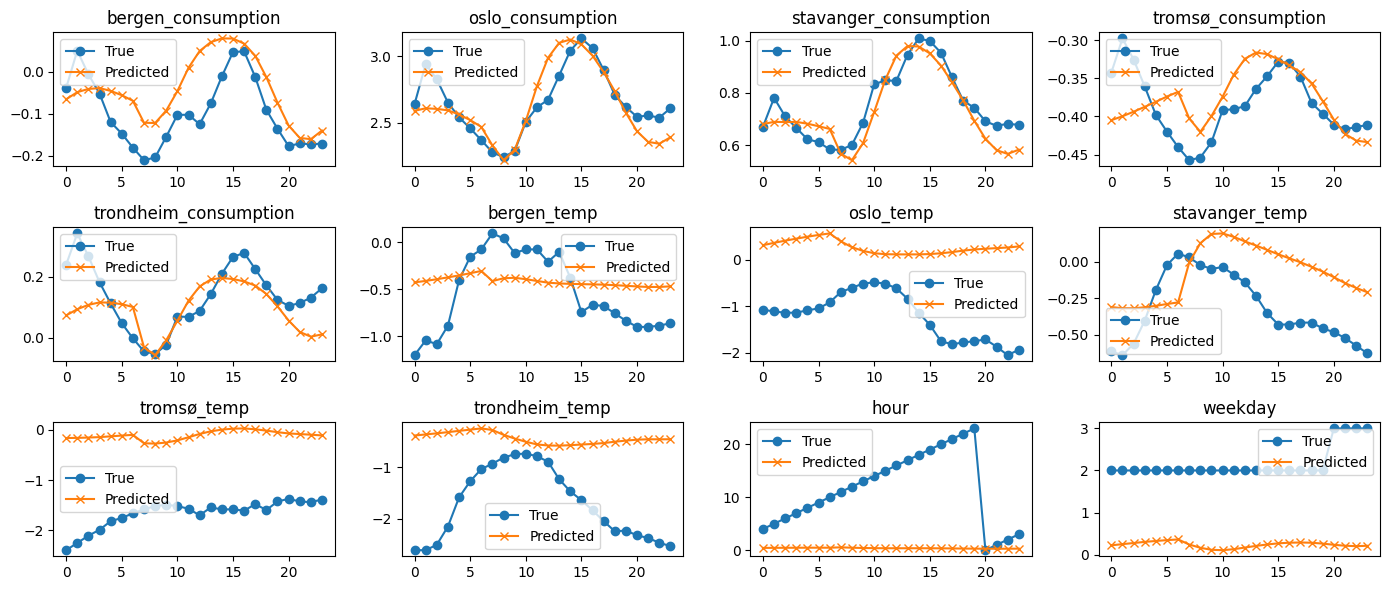

In [20]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X)

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(12):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# LSTM Take 2

In [21]:
class VectorOutputLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, n_future, device):
        super(VectorOutputLSTM, self).__init__()

        self.device = device
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim * n_future)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device).requires_grad_()
        
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.linear(out[:, -1, :])
        
        # Reshape to get predictions for the future time steps
        return out.view(x.size(0), -1)
    
# model = VectorOutputLSTM(12, 64, 1, 12, 5, 'cuda')
# total_params, trainable_params = count_parameters(model)
# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")

In [22]:
model = VectorOutputLSTM(12, 64, 1, 5, WINDOW_SIZE_Y+GAP_PREDICTION, 'cuda').to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12, device='cuda')
out = model(input)
print(out.shape)

torch.Size([25, 185])


In [23]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VectorOutputLSTM(12, 64, 1, 5, WINDOW_SIZE_Y+GAP_PREDICTION, 'cuda').to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_X, train_y, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]
        # print(outputs.shape)

        train_y = train_y[:,:,:5]
        # print(train_y.shape)

        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs.view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model(model, train_X, train_y, criterion, optimizer, epochs=1000)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/1000], Loss: 0.8473
Epoch [20/1000], Loss: 0.6195
Epoch [30/1000], Loss: 0.3645
Epoch [40/1000], Loss: 0.1677
Epoch [50/1000], Loss: 0.0793
Epoch [60/1000], Loss: 0.0529
Epoch [70/1000], Loss: 0.0426
Epoch [80/1000], Loss: 0.0373
Epoch [90/1000], Loss: 0.0337
Epoch [100/1000], Loss: 0.0313
Epoch [110/1000], Loss: 0.0294
Epoch [120/1000], Loss: 0.0282
Epoch [130/1000], Loss: 0.0270
Epoch [140/1000], Loss: 0.0261
Epoch [150/1000], Loss: 0.0253
Epoch [160/1000], Loss: 0.0246
Epoch [170/1000], Loss: 0.0241
Epoch [180/1000], Loss: 0.0235
Epoch [190/1000], Loss: 0.0231
Epoch [200/1000], Loss: 0.0225
Epoch [210/1000], Loss: 0.0225
Epoch [220/1000], Loss: 0.0221
Epoch [230/1000], Loss: 0.0213
Epoch [240/1000], Loss: 0.0210
Epoch [250/1000], Loss: 0.0206
Epoch [260/1000], Loss: 0.0202
Epoch [270/1000], Loss: 0.0198
Epoch [280/1000], Loss: 0.0195
Epoch [290/1000], Loss: 0.0199
Epoch [300/1000], Loss: 0.0191
Epoch [310/1000], Loss: 0.0186
Epoch [320/1000], Loss: 0.0183
Epoch [330/1000],

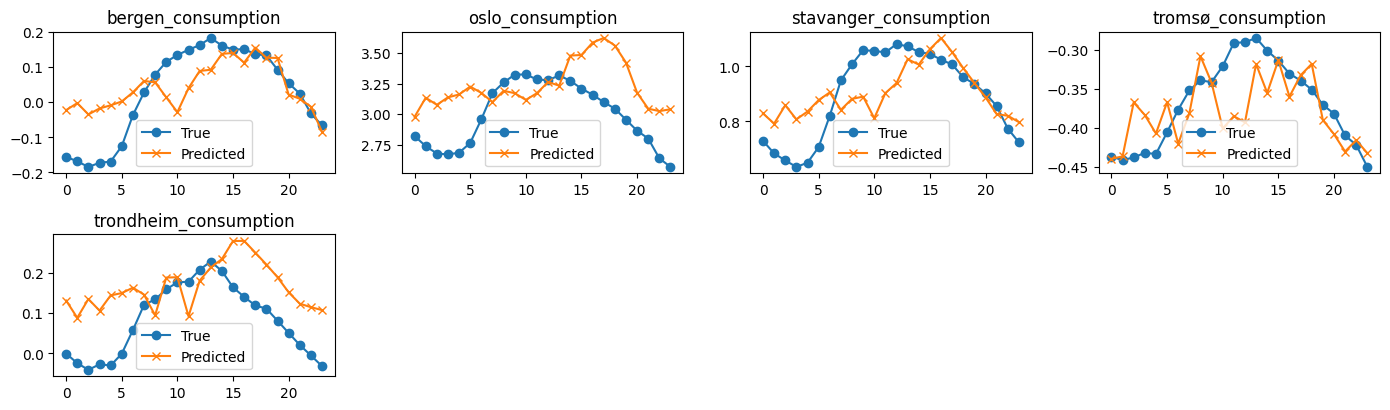

In [24]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(5):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# Transformer

In [25]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
                 feature_size=12, 
                 num_layers=1, 
                 num_heads=6, 
                 feedforward_dim=64, 
                 dropout=0.1, 
                 output_size=12):
        super(TimeSeriesTransformer, self).__init__()
        
        self.feature_size = feature_size
        
        self.positional_encoding = nn.Parameter(torch.randn(1, 107, feature_size))
        
        self.transformer = nn.Transformer(d_model=feature_size, 
                                          nhead=num_heads, 
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, 
                                          dim_feedforward=feedforward_dim, 
                                          dropout=dropout)
        
        self.linear = nn.Linear(feature_size, output_size)
        
    def forward(self, x, verbose=False):
        # Add positional encoding
        x = x + self.positional_encoding

        if verbose:
            print('1:', x.shape)
        
        # Transformer expects tgt (target tensor) for supervised tasks, but for our forecasting task
        # We'll use shifted input as target (this is a common trick for time series forecasting)
        tgt = torch.roll(x, shifts=-1, dims=1)

        if verbose:
            print('2:', tgt.shape)
        
        # Apply transformer
        out = self.transformer(x, tgt)

        if verbose:
            print('3:', out.shape)
        
        # Use relevant steps from the transformer output
        out = out[:, GAP_PREDICTION:GAP_PREDICTION+WINDOW_SIZE_Y, :]

        if verbose:
            print('4:', out.shape)
        
        # Pass through linear layer
        out = self.linear(out)

        if verbose:
            print('5:', out.shape)
        
        return out
    
model = TimeSeriesTransformer()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6704
Trainable parameters: 6704


In [26]:
model = TimeSeriesTransformer()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12)
out = model(input, verbose=True)

1: torch.Size([25, 107, 12])
2: torch.Size([25, 107, 12])
3: torch.Size([25, 107, 12])
4: torch.Size([25, 24, 12])
5: torch.Size([25, 24, 12])


In [28]:
from torch.utils.data import DataLoader, TensorDataset

model = TimeSeriesTransformer(dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop with mini-batches
def train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size, epochs):
    model.train()
    
    # Create DataLoader for batching
    dataset = TensorDataset(train_X, train_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = outputs[:,:,:5]
            batch_y = batch_y[:,:,:5]
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(train_X)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs[:,:,:5]
        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size=128, epochs=100)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/100], Loss: 0.0437
Epoch [20/100], Loss: 0.0382
Epoch [30/100], Loss: 0.0344
Epoch [40/100], Loss: 0.0345
Epoch [50/100], Loss: 0.0322
Epoch [60/100], Loss: 0.0298
Epoch [70/100], Loss: 0.0284
Epoch [80/100], Loss: 0.0281
Epoch [90/100], Loss: 0.0267
Epoch [100/100], Loss: 0.0260
Test Loss: 0.0230


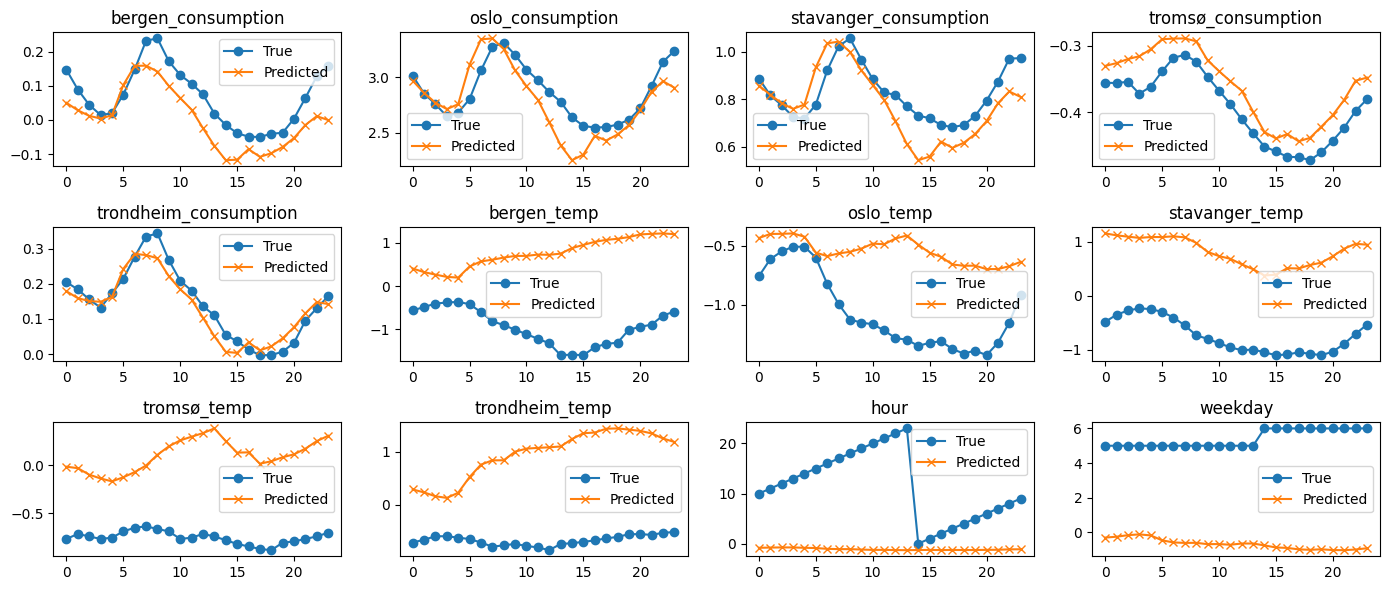

In [29]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X)

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(12):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# Transformer take 2

In [30]:
class TransformerForecasting(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, output_dim, n_future):
        super(TransformerForecasting, self).__init__()

        # Embedding layer: This layer converts the input features into embeddings of dimension d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_encoder_layers
        )

        # Output layer: Produces a vector for future time steps
        self.output_layer = nn.Linear(d_model, output_dim * n_future)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(x[:, -1, :])  # Only consider the last time step's output for forecasting
        return x.view(x.size(0), -1)

In [31]:
# # from trans1
# feature_size=12, 
# num_layers=1, 
# num_heads=6, 
# feedforward_dim=64, 
# dropout=0.1, 
# output_size=12

# # --
# input_dim = 1  # number of features in your input
# d_model = 64  # dimension of the model; traditionally 512, but can be smaller for our purposes
# nhead = 4  # number of attention heads
# num_encoder_layers = 3
# output_dim = 1  # number of features in your output
# n_future = 5  #

In [32]:
model = TransformerForecasting(12, 64, 2, 3, 5, WINDOW_SIZE_Y+GAP_PREDICTION).to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = T.randn(25, 107, 12, device='cuda')
out = model(input)
print(out.shape)

torch.Size([25, 185])


In [34]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecasting(12, 64, 2, 3, 5, WINDOW_SIZE_Y+GAP_PREDICTION).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size, epochs):
    model.train()
    
    # Create DataLoader for batching
    dataset = TensorDataset(train_X, train_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]
            batch_y = batch_y[:,:,:5]
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(train_X)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

# Evaluation loop
def evaluate_model(model, test_X, test_y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)

        outputs = outputs.view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

        test_y = test_y[:,:,:5]
        
        loss = criterion(outputs, test_y)
    return loss.item()

# Train the model
train_model_batched(model, train_X, train_y, criterion, optimizer, batch_size=64, epochs=100)

# Evaluate the model
test_loss = evaluate_model(model, test_X, test_y, criterion)
print(f'Test Loss: {test_loss:.4f}')

Epoch [10/100], Loss: 0.0233
Epoch [20/100], Loss: 0.0196
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0118
Epoch [60/100], Loss: 0.0107
Epoch [70/100], Loss: 0.0094
Epoch [80/100], Loss: 0.0091
Epoch [90/100], Loss: 0.0077
Epoch [100/100], Loss: 0.0065
Epoch [10/100], Loss: 0.0074
Epoch [20/100], Loss: 0.0061
Epoch [30/100], Loss: 0.0056
Epoch [40/100], Loss: 0.0051
Epoch [50/100], Loss: 0.0051
Epoch [60/100], Loss: 0.0048
Epoch [70/100], Loss: 0.0042
Epoch [80/100], Loss: 0.0040
Epoch [90/100], Loss: 0.0037
Epoch [100/100], Loss: 0.0038
Test Loss: 0.0036


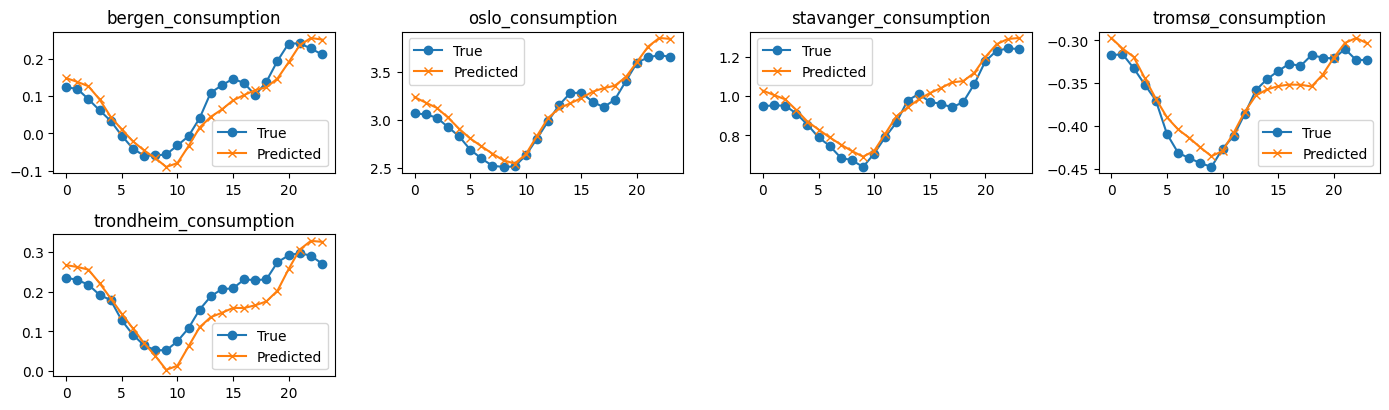

In [35]:
# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_X).view(-1, WINDOW_SIZE_Y+GAP_PREDICTION, 5)[:,:WINDOW_SIZE_Y,:]

# Choose a random sample from the test set
sample_idx = torch.randint(0, test_X.size(0), (1,)).item()
sample_true = test_y[sample_idx].numpy(force=True)
sample_pred = predictions[sample_idx].numpy(force=True)

# Plotting
plt.figure(figsize=(14, 6))

for i in range(5):  # For each of the 12 features
    plt.subplot(3, 4, i+1)
    plt.plot(sample_true[:, i], label='True', marker='o')
    plt.plot(sample_pred[:, i], label='Predicted', marker='x')
    plt.title(f'{df_merged.columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

# TST from paper

In [ ]:
from tsai.all import *

In [ ]:
bs = 64
c_in = 12  # aka channels, features, variables, dimensions
c_out = 5
seq_len = 107

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 256
d_model = 128
n_heads = 6
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
dropout = 0.1
n_layers = 3
fc_dropout = 0.1
kwargs = {}

model = TST(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, n_layers=n_layers,
            fc_dropout=fc_dropout, **kwargs)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 476677


In [ ]:
model(T.rand((10, 12, 107))).shape

torch.Size([10, 5])